# Music Valence Prediction: Classic Models

Spotify data | Gradient boosting

***

## Project Description

### The problem

The main task of this project is to develop a python-based module to predict valence of newly released pop songs.   

*Valence* is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

### The dataset

In this version of the project, Spotify data will be used: audio features and 30-second audio previews, available with the `spotify` library.

### Audio Signal Features
<a id="audio-features"></a>

In this version of the project, the approach of the following research paper will be implemented: [Measuring national mood with music](https://link.springer.com/article/10.3758/s13428-021-01747-7). Specifically, the same [set of features](https://static-content.springer.com/esm/art%3A10.3758%2Fs13428-021-01747-7/MediaObjects/13428_2021_1747_MOESM1_ESM.pdf).
- Spectral Centroid;
- Spectral Rolloff;
- Spectral Contrast — ~~7 bands~~ *(kept the default 6 bands instead)*;
- Mel-Frequency Cepstrum Coefficients (MFCC) — 24 coefficients;
- Zero Crossing Rate;
- Chroma Energy Normalized Statistics (CENS) — 12 chroma;
- Beat Per Minute (BPM);
- Root Mean Square (RMS);

### The Dataset

Fr this task, the more recent version of this dataset will be used: [DEAM dataset](https://cvml.unige.ch/databases/DEAM/). It seemingly has a more diverse range of music genres, including electronic and Hip-hop music, which are absent in the previous version.

***

## Imports and settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd

from scipy import stats as st
from scipy.signal import get_window

import os
import re
from tqdm import tqdm
from time import time
from datetime import date

In [2]:
# set up some parameters for plots in this notebook
plt.style.use("seaborn-v0_8")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("rocket")

plt.rcParams["figure.figsize"] = (10, 4)
%config InlineBackend.figure_format = "retina"

In [3]:
# save random state number in advance
seed = 12345

***

## EDA

### Read the data

In [4]:
data = pd.read_csv("spotify_data/songs_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   artist           6800 non-null   object 
 1   artist_uri       6800 non-null   object 
 2   track_name       6800 non-null   object 
 3   track_id         6800 non-null   object 
 4   track_uri        6800 non-null   object 
 5   preview_url      6800 non-null   object 
 6   tempo            6800 non-null   float64
 7   energy           6800 non-null   float64
 8   danceability     6800 non-null   float64
 9   loudness         6800 non-null   float64
 10  valence          6800 non-null   float64
 11  local_file_path  6800 non-null   object 
dtypes: float64(5), object(7)
memory usage: 637.6+ KB


### Audio and waveform

Sampling rate: 22050
artist                                                   Ed Maverick
artist_uri                     spotify:artist:3JSSjGYcIkgsrz7892CelT
track_name                                                mantra II,
track_id                                      2XcWZWstxIKrpjrpPLCw5m
track_uri                       spotify:track:2XcWZWstxIKrpjrpPLCw5m
preview_url        https://p.scdn.co/mp3-preview/5d99f653fc7228eb...
tempo                                                         99.684
energy                                                         0.359
danceability                                                   0.623
loudness                                                       -9.64
valence                                                        0.101
local_file_path    spotify_data/mp3_files/2XcWZWstxIKrpjrpPLCw5m.mp3
Name: 6393, dtype: object


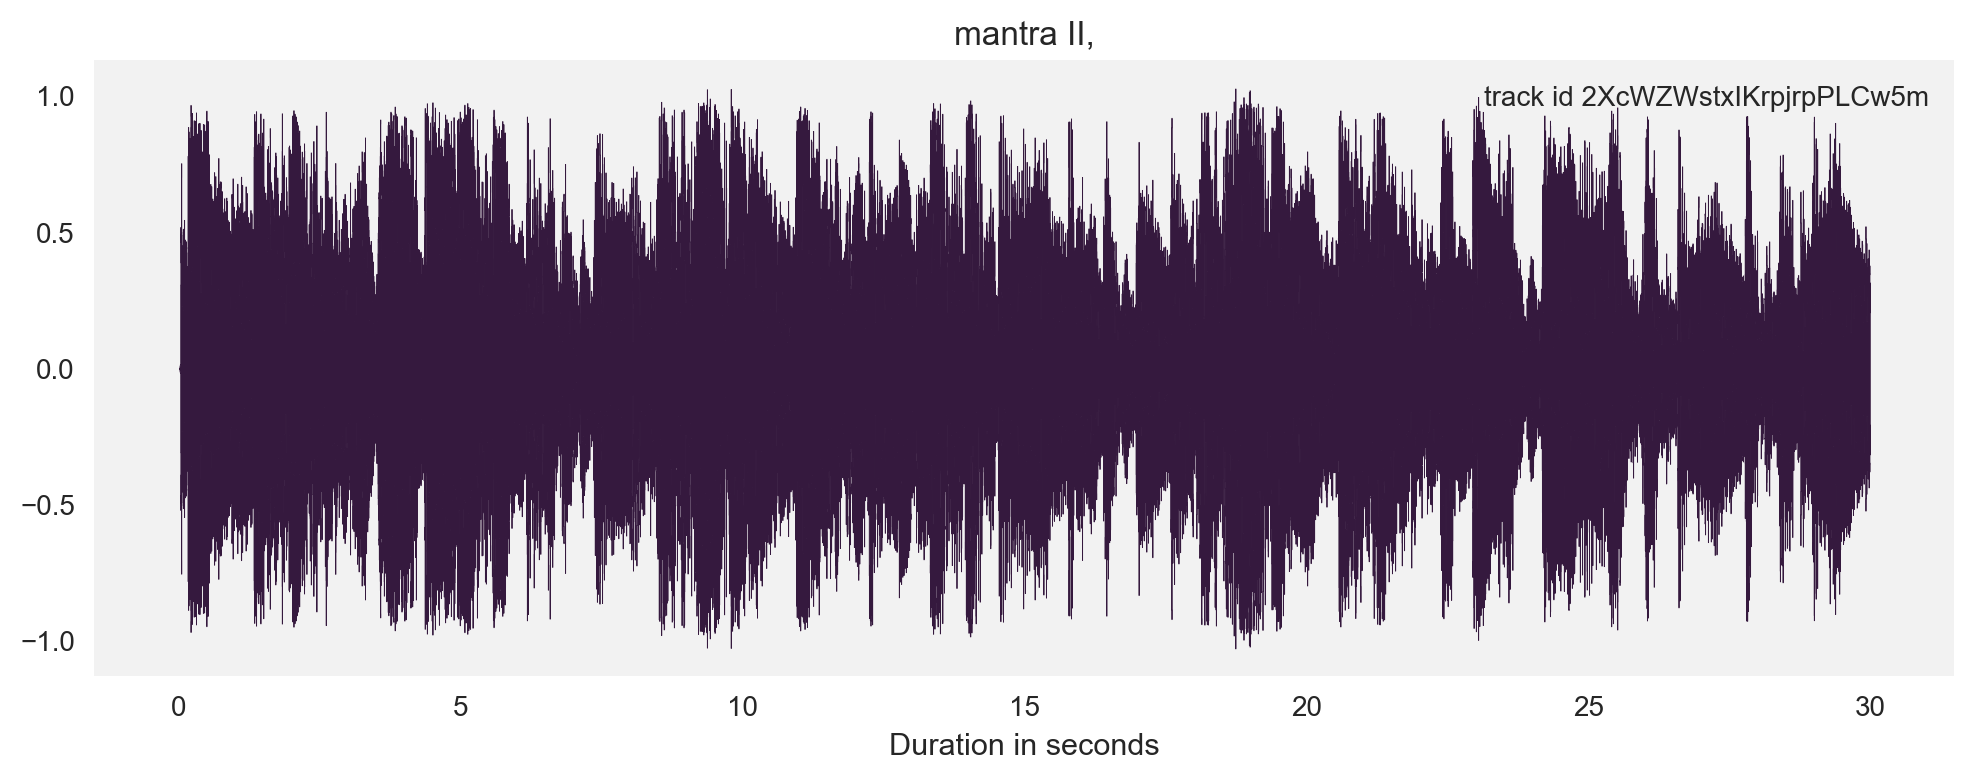

In [11]:
random_idx = np.random.randint(0, 6800)

# select a random song from the dataset
arb_song = data.loc[random_idx, :]

# load the file and print its sampling rate 
file_path = arb_song["local_file_path"]
y, sr = librosa.load(file_path)
# print info about this song
print(f"Sampling rate: {sr}")
print(arb_song)

# plot the wavefrom
plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr) # plot a waveform and play the file
plt.title(f"{arb_song.track_name}")
plt.legend([f"track id {arb_song.track_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

***

## Audio Features

Investigate the audio features available with the `librosa` library.

### Spectral Centroid 

The spectral centroid is a measure of the center of gravity of a sound. This can be used to classify the timbre of a sound, and also to identify different types of sounds. It can be used in applications such as Notion AI, where it can be used to identify particular sounds in a recording.

NameError: name 'song' is not defined

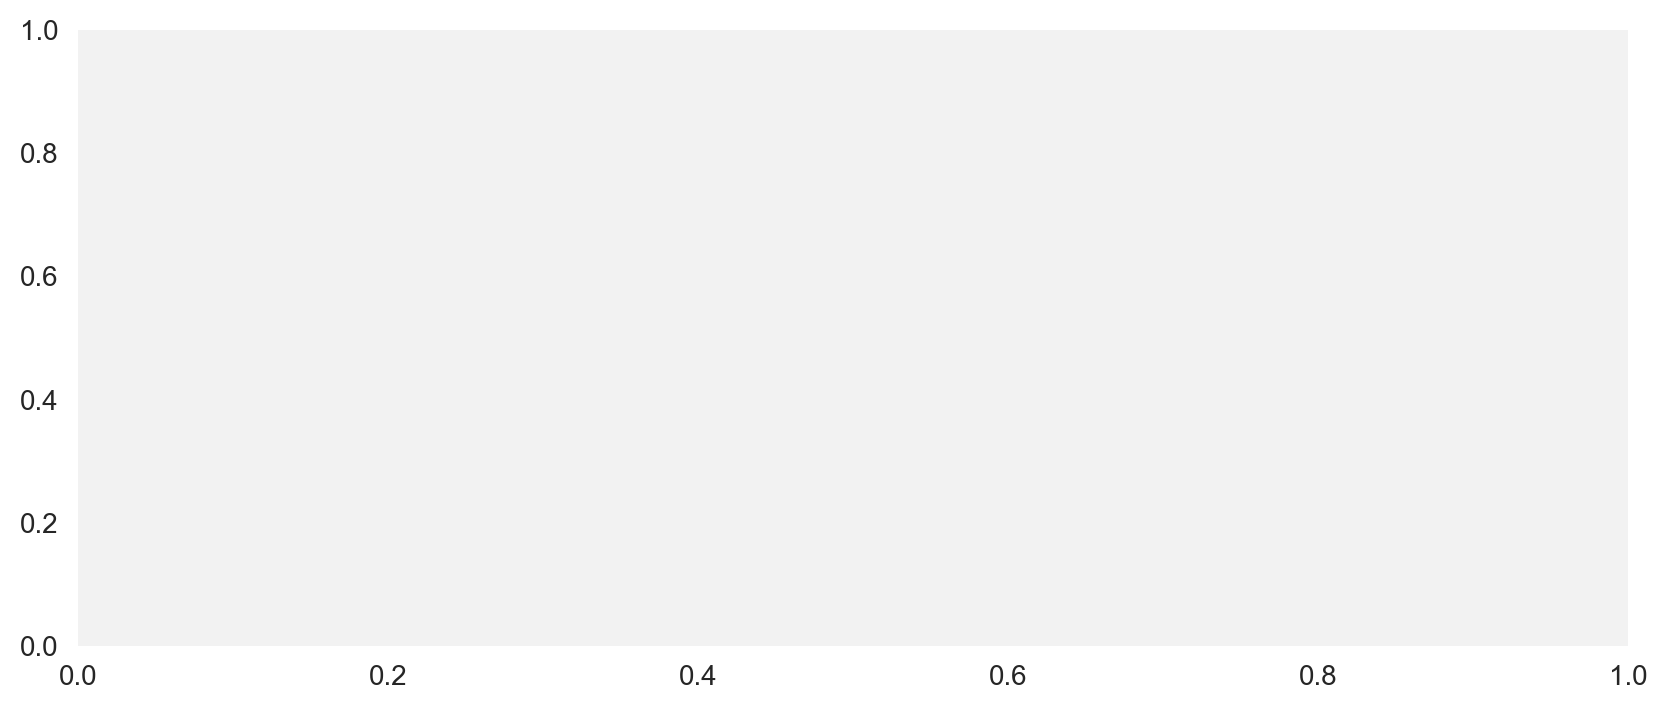

In [7]:
# derive the feature from the audio file
cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)

# obtain other data for plotting
S, phase = librosa.magphase(librosa.stft(y=audio))
times = librosa.times_like(cent)

fig, ax = plt.subplots()
ax.set(title=f"Spectral Centroid for song id {song.song_id}")

# show spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis="log", x_axis="time", ax=ax)
# plot spectral centroid
ax.plot(times, cent.T, label="Spectral centroid",  color="w")
ax.legend(loc="upper right");

### Spectral Rolloff

Spectral rolloff is a feature of audio signal analysis which measures how quickly the power of a signal decreases as the frequency increases. It can be used to identify the tonal components of a signal and detect the presence of harmonic content.

In [ ]:
# approximate minimum frequencies with roll_percent=0.95
rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.95)
# approximate minimum frequencies with roll_percent=0.50
rolloff_middle = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.5)
# approximate minimum frequencies with roll_percent=0.01
rolloff_min = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.01)

S, phase = librosa.magphase(librosa.stft(audio))

fig, ax = plt.subplots()
ax.set(title=f"Spectral Roll-off for song id {song.song_id}")

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis="log", x_axis="time", ax=ax)

ax.plot(librosa.times_like(rolloff), rolloff[0], label="Roll-off freq 0.95", color="c")
ax.plot(librosa.times_like(rolloff), rolloff_middle[0], label="Roll-off freq 0.50", color="w")
ax.plot(librosa.times_like(rolloff), rolloff_min[0], label="Roll-off freq 0.01", color="y")
ax.legend(loc='center right');

### Spectral Contrast

Spectral contrast, as implemented in the librosa library, is used to highlight the differences in frequency content of a signal, and can be used to detect and identify individual instruments, as well as providing general information about the signal. The process of spectral contrast works by measuring the overall average energy of each frequency band, then subtracting this average from the original signal. This reveals the differences in the signal which would otherwise be difficult to detect. By doing this, spectral contrast can provide an understanding of the structure of a sound, and can even be used to detect and identify individual instruments.

In [ ]:
S = np.abs(librosa.stft(y=audio))
contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate, n_bands=6)

fig, ax = plt.subplots()

# plot spectral contrast
img2 = librosa.display.specshow(contrast, x_axis="time", ax=ax)
fig.colorbar(img2, ax=ax)
ax.set(ylabel="Frequency bands", title=f"Spectral contrast for song id {song.song_id}");

### Mel-Frequency Cepstrum Coefficients

MEL-Frequency Cepstrum Coefficients (MFCCs) are a powerful technique for recognizing patterns in audio signals. They are used to represent audio signals in a form that is more easily analyzed by a machine. MFCCs are derived from a Fourier transform of a signal and are used in speech recognition and music recognition applications. MFCCs are also used in audio fingerprinting and speaker recognition.

In [ ]:
 # generate mfccs from the audio file
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=24)

fig, ax = plt.subplots()

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title=f"Mel-Frequency Cepstrum Coefficients for song id {song.song_id}");

### Onset Strength

The onset strength is used to measure the intensity of different sounds in audio files. It is an important measure to consider when analyzing audio signals, as it can help determine the loudness and intensity of a sound in comparison to other sounds. The OS algorithm is also used to identify and differentiate between different types of sounds, making it particularly useful for audio classification.

In [ ]:
# locate note onset events by picking peaks in an onset strength envelope
# select only a slice for better visualisation
onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)[750:1000]
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sample_rate)
times = librosa.times_like(onset_env, sr=sample_rate)

fig, ax = plt.subplots()
ax.set(title=f"The Onset Strength for the song id {song.song_id}", xlabel="Time")

ax.plot(times, onset_env, label='Onset strength')
ax.vlines(times[onset_frames], 0, onset_env.max(), color='r', alpha=0.3, linestyle='--', label='Onsets')
ax.legend();

### Zero Crossing Rate

The Zero Crossing Rate (ZCR) is a measure used in signal processing to identify the number of times a signal crosses the zero axis. It is often used to analyze audio signals, as it can provide an indication of the perceptual loudness of the audio. ZCR can be calculated by counting the number of times the signal crosses the zero axis in a given time interval.

In [ ]:
zcrs = librosa.feature.zero_crossing_rate(audio)

plt.plot(zcrs[0])
plt.title(f"Zero Crossing Rates for song id {song.song_id}");

### Chroma Energy Normalized Statistics

CENS is calculated by first computing the chroma vectors for each audio signal. The chroma vector is a 12-dimensional vector composed of the energy in each of the 12 semitones of an octave. The chroma vectors of each signal are then normalized to have unit energy. Finally, the normalized chroma vectors are compared using a similarity measure such as cosine distance.

In [ ]:
chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sample_rate)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_cens, y_axis="chroma", x_axis="time")
fig.colorbar(img)
ax.set(title=f"Chroma CENS for song id {song.song_id}");

### Beats Per Minute: Dynamic Tempo

The tempo of a song can be defined as its speed, or how quickly the music moves. It can range from slow and gentle to fast and intense, depending on the genre and style of the music. In a dynamic tempo, the speed of the music changes throughout the song, creating a sense of excitement and anticipation. This can be done by increasing the tempo gradually or by sudden changes in speed.

In [ ]:
onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate, aggregate=None)

fig, ax = plt.subplots()
tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sample_rate, hop_length=512)
librosa.display.specshow(tg, x_axis="time", y_axis="tempo", cmap="magma", ax=ax)

ax.plot(librosa.times_like(dtempo), dtempo, color="w", linewidth=1.5, label="Tempo estimate")

ax.set(title=f"Dynamic tempo estimation for song id {song.song_id}")
ax.legend();

### Root Mean Square

RMS is a measure of the average power of a signal over time. It is useful for comparing the loudness of different audio signals, as well as for analyzing the spectral content of signals. 

In [ ]:
rms = librosa.feature.rms(y=audio)[0]

fig, ax = plt.subplots()
times = librosa.times_like(rms)
ax.set(title=f"RMS energy for each frame for song id {song.song_id}", xlabel="Time")
ax.semilogy(times, rms, label='RMS Energy');

***

## Features Extraction

Write an algorithm which will extract audio features from every song in the dataset.

### Stats function

In [ ]:
def get_stats(array):
    """
    Takes an array and gives back its mean, standard deviation, 
    first-order difference mean, and first-order difference 
    standard deviation — in this exact order.
    """
    mean = array.mean()
    var = array.var()
    
    diff_mean = np.diff(array).mean()
    diff_var = np.diff(array).var()
    
    return [mean, var, diff_mean, diff_var]

### Features extraction function

In [ ]:
def extract_features(file_path):
    """
    Takes path to an audio file and returns statistics (mean, standard deviation, 
    first-order difference mean, and first-order difference standard deviation)
    for each output array of the following methods:
    
    - Spectral Centroid (1)
    - Spectral Rolloff (3)
    - Spectral Contrast (7)
    - MFCC (24)
    – Onset Strength (1)
    – Zero Crossing Rate (1)
    – CENS (12)
    – BPM Dynamic (1)
    – RMS (1)
    
      204 values output in total.
      
    """
    features = [] # empty list for storing features
    cnt = 0 # counter for keeping track of features number
    
    # load the audio file 
    audio, sample_rate = librosa.load(file_path)
    
    # Spectral Centroid
    cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    features.append(get_stats(cent))
    cnt += 1
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.95)
    features.append(get_stats(rolloff))
    cnt += 1
    
    rolloff_middle = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.5)
    features.append(get_stats(rolloff_middle))
    cnt += 1
    
    rolloff_min = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.01)
    features.append(get_stats(rolloff_min))
    cnt += 1
    
    # Spectral Contrast
    S = np.abs(librosa.stft(y=audio))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate)
    for band in contrast:
        features.append(get_stats(band))
        cnt += 1
        
    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=24)
    for mfcc in mfccs:
        features.append(get_stats(mfcc))
        cnt += 1
    
    # Onset strength
    onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
    features.append(get_stats(onset_env))
    cnt += 1
    
    # ZCR
    zcrs = librosa.feature.zero_crossing_rate(audio)
    features.append(get_stats(zcrs))
    cnt += 1
    
    # CENS
    chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sample_rate)
    for chroma in chroma_cens:
        features.append(get_stats(chroma))
        cnt += 1
        
    # BPM
    dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate, aggregate=None)
    features.append(get_stats(dtempo))
    cnt += 1
    
    # RMS
    rms = librosa.feature.rms(y=audio)[0]
    features.append(get_stats(rms))
    cnt += 1
    
    features = np.array(features).reshape(cnt * 4)
    
    return features

### Extract features

In [121]:
# features_df = []
# for i in tqdm(range(len(data))):
    
#     file_name = data.loc[i, "file_name"]
#     file_path = "datasets/audio_files/" + file_name
#     features_df.append(extract_features(file_path))

### Save column names

In [33]:
# create a featuers amount lookup table
lkp_dict = dict(centroid=1, rolloff_high=1, rolloff_mid=1, rolloff_min=1, 
              contrast=7, mfcc=24, onset=1, zcr=1, cens=12, bpm=1, rms=1)

In [34]:
column_names = []
statistics = ["mean","var","diff_mean","diff_var"]

for feature in lkp_dict:
    for i in range(1, lkp_dict[feature] + 1, 1):
        for statistic in statistics:
            if lkp_dict[feature] != 1:
                column_names.append(feature + "_" + str(i) + "_" + statistic)
            else:
                column_names.append(feature + "_" + statistic)

In [ ]:
features_df = pd.read_csv("features_df_2022-12-23.csv", index_col=0)

In [35]:
features_df = pd.DataFrame(np.array(features_df), columns=column_names) 

In [122]:
# # save the extracted features for future use
# curr_date = date.today().strftime("%Y-%m-%d")
# features_df.to_csv("features_df_" + curr_date + ".csv")

***

## Model Training

In [1]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

from imblearn.pipeline import Pipeline, make_pipeline

### Prepare features

In [37]:
X = features_df.values
y = data.valence.values

# split the data into the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

print(X_train.shape)
print(X_test.shape)

(1395, 204)
(349, 204)


### Evaluation Procedure

In [38]:
# creata a function for models evaluation
def eval_model(model, X=X_train, y=y_train, show_metrics=1):
    
    # create a pipline to avoid possible target leakage
    pipe = make_pipeline(StandardScaler(), model)
    
    scores = cross_validate(pipe, X, y, cv=5, scoring=("r2", "neg_mean_absolute_error"), n_jobs=-1)
    
    r2 = np.average(scores["test_r2"])
    mae = abs(np.average(scores["test_neg_mean_absolute_error"]))
    fit_time = np.average(scores["fit_time"])
    score_time = np.average(scores["score_time"])
    
    if show_metrics == 1:
        print("Fit time: {:.5f}".format(fit_time))
        print("Score time: {:.5f}".format(score_time))
        print("R2: {:.4f}".format(r2))
        print("MAE {:.4f}".format(mae))
    else:
        return r2, mae

### LinearRegresssion

In [39]:
eval_model(LinearRegression())

Fit time: 0.01562
Score time: 0.00063
R2: 0.4187
MAE 0.6986


### SVR

In [40]:
eval_model(SVR())

Fit time: 0.11258
Score time: 0.04413
R2: 0.5415
MAE 0.6319


In [41]:
# try different C parameters
for C in range(1, 10):
    r2, mae = eval_model(SVR(C=C), show_metrics=0)
    print("C {} | R2: {:.4f}  MAE: {:.4f}".format(C, r2, mae))

C 1 | R2: 0.5415  MAE: 0.6319
C 2 | R2: 0.5506  MAE: 0.6254
C 3 | R2: 0.5517  MAE: 0.6251
C 4 | R2: 0.5504  MAE: 0.6266
C 5 | R2: 0.5483  MAE: 0.6284
C 6 | R2: 0.5469  MAE: 0.6291
C 7 | R2: 0.5464  MAE: 0.6296
C 8 | R2: 0.5460  MAE: 0.6297
C 9 | R2: 0.5457  MAE: 0.6296


The best scoring is when `C = 3`.

### RandomForestRegressor

In [42]:
eval_model(RandomForestRegressor(random_state=seed, n_jobs=-1))

Fit time: 3.49509
Score time: 0.01349
R2: 0.5526
MAE 0.6263


It takes much longer to train and the metrics are not improving much. Try GridSearch for better hyperparameters.

In [43]:
# parameters grid
params = dict(
    n_estimators = [20, 50, 100],
    max_depth = range(10, 23, 2),
    max_features = ["sqrt","log2", "auto"]
)
# initialize the model and the scaler
forest = RandomForestRegressor(random_state=seed, n_jobs=-1)
scaler = StandardScaler()

scale_pipeline = Pipeline([
    ("scaler", scaler),
    ("forest", forest)
])

# update parameter names for grid search using pipeline
new_params = {"forest__" + key: params[key] for key in params}
grid = GridSearchCV(estimator=scale_pipeline, param_grid=new_params, n_jobs=-1, cv=5, scoring="r2")
grid_result = grid.fit(X_train, y_train)

print("Best R2: {:.4f} \nUsing params:\n{}".format(grid_result.best_score_, grid_result.best_params_))

Best R2: 0.5536 
Using params:
{'forest__max_depth': 16, 'forest__max_features': 'auto', 'forest__n_estimators': 100}


### CatBoost

In [44]:
eval_model(CatBoostRegressor(random_seed=seed, verbose=0))

Fit time: 20.95246
Score time: 0.00954
R2: 0.5870
MAE 0.6034


Good result. Try to improve with hyperparameters grid search.

In [48]:
start = time()
# parameters grid
params = dict(
    depth = range(3, 8, 1),
    learning_rate = np.arange(.01, .15, .02),
    l2_leaf_reg = range(1, 6, 1)
)
# initialize the model and the scaler
cat = CatBoostRegressor(random_seed=seed, verbose=0)
scaler = StandardScaler()

scale_pipeline = Pipeline([
    ("scaler", scaler),
    ("cat", cat)
])

# update parameter names for grid search using pipeline
new_params = {"cat__" + key: params[key] for key in params}
grid = GridSearchCV(estimator=scale_pipeline, param_grid=new_params, n_jobs=-1, cv=5, scoring="r2")
grid_result = grid.fit(X_train, y_train)

min_spent = (time() - start) / 60
print("Time spent on searching: {:.2} mins".format(min_spent))
print("Best R2: {:.4f} \nUsing params:\n{}".format(grid_result.best_score_, grid_result.best_params_))

Time spent on searching: 5.2e+01 mins
Best R2: 0.5936 
Using params:
{'cat__depth': 5, 'cat__l2_leaf_reg': 1, 'cat__learning_rate': 0.03}


***

## Results Analysis

### Check on the test set

In [49]:
# scale the the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

cat = CatBoostRegressor(random_seed=seed, verbose=0,depth=5,
                        learning_rate=.03, l2_leaf_reg=1)

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R2: {:.4f}".format(r2))
print("MAE {:.4f}".format(mae))

R2: 0.5575
MAE 0.6084


### Features importance analysis

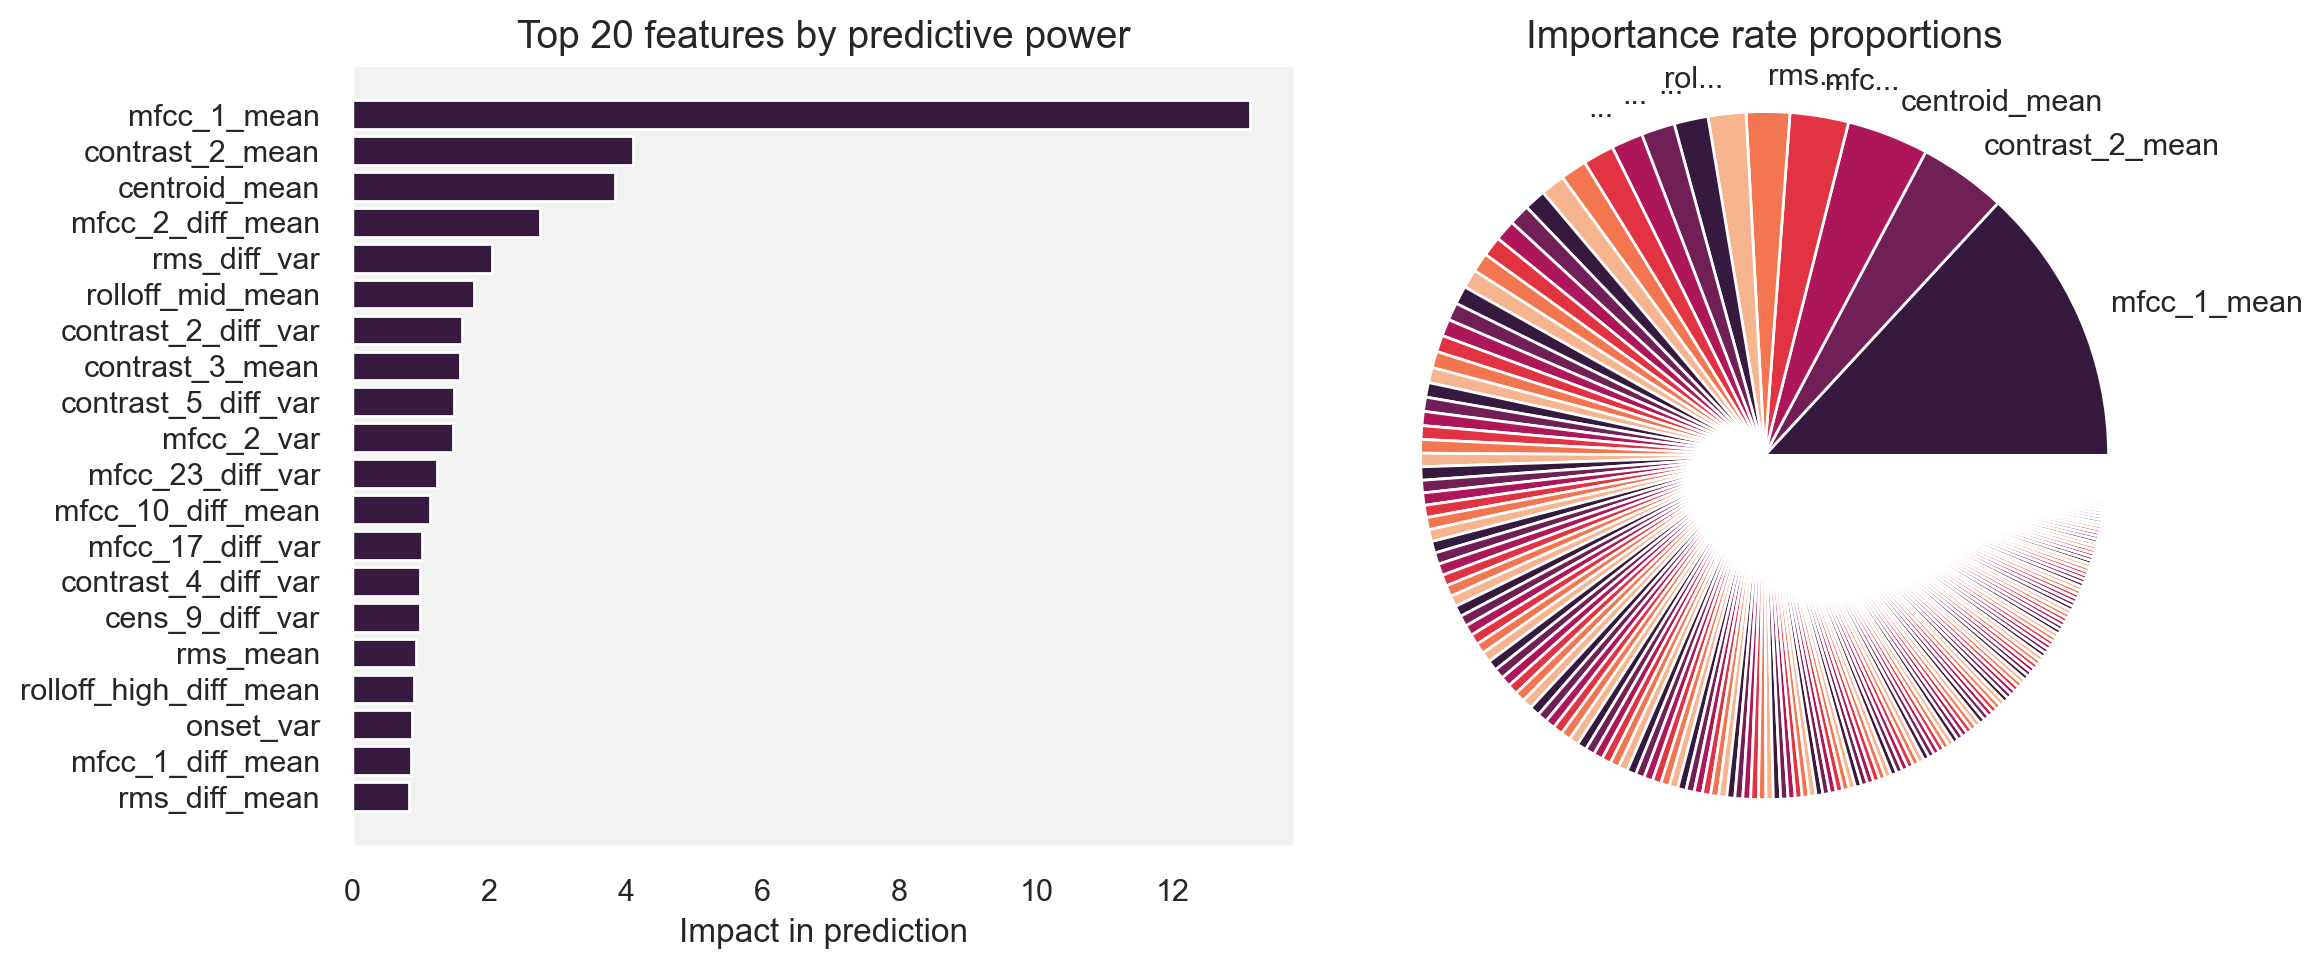

In [120]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))

# get features importance rate
feature_importance = cat.get_feature_importance()
feature_importance = pd.Series(feature_importance, index=column_names).sort_values()

ax = axs[0]
ax.barh(feature_importance.index[-20:], feature_importance.values[-20:])
ax.set_title("Top 20 features by predictive power", fontsize=14)
ax.set_xlabel("Impact in prediction")

# prepare data for making a pie chart
feature_importance.sort_values(ascending=False, inplace=True)
# modify labels list so it will fit on the graph
# labels = [f"{i:.1f}%" for i in feature_importance.values[:6]]
labels = [i for i in feature_importance.index[:3]]
[labels.append(i[:3]+"...") for i in feature_importance.index[3:6]]
[labels.append("...") for i in range(6 ,9,1)]
[labels.append("") for i in range(9 ,204,1)]

ax = axs[1]
ax.pie(feature_importance, labels=labels, radius=1.1 )
ax.set_title("Importance rate proportions", fontsize=14)

fig.tight_layout();

The first array of Mel-Frequency Cepstrum Coefficients (MFCCs) stands out, but the importance of every next feature gradually deceases without any dramatic changes.

***

## Python module script [TBD]